In [1]:
import uproot4
import pandas as pd
import numpy as np
import ROOT
import matplotlib.pyplot as plt

def open_root4(path):
    """
    Open a ROOT file, extract specific branches, and process the data into a Pandas DataFrame.
    
    Parameters:
        path (str): The path to the ROOT file.

    Returns:
        pd.DataFrame: A DataFrame containing the processed data.
    """
    # Open the ROOT file and get the Delphes tree
    file = uproot4.open(path)
    tree = file['Delphes']

    # Specify the branches to extract
    branches = [
        'Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.TauTag',
        'Electron.PT', 'Electron.Eta', 'Electron.Phi',
        'Muon.PT', 'Muon.Eta', 'Muon.Phi',
        'MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'
    ]

    # Extract the data from the tree as a dictionary of arrays
    data = tree.arrays(branches, library='pd')

    # Convert to a Pandas DataFrame
    df = pd.DataFrame(data)

    # Calculate Jet.Theta from Jet.Eta
    df['Jet.Theta'] = df['Jet.Eta'].apply(lambda eta_list: [2 * np.arctan(np.exp(-eta)) for eta in eta_list])

    # Insert Jet.Theta as the 2nd column
    df.insert(2, 'Jet.Theta', df.pop('Jet.Theta'))

    # Count the number of jets in each event
    df['Jet Count'] = df['Jet.PT'].apply(len)

    # Combine Muon.PT and Electron.PT into a single list for each row
    df['Lepton.PT'] = df.apply(lambda row: row['Muon.PT'] + row['Electron.PT'], axis=1)
    df['Lepton.Eta'] = df.apply(lambda row: row['Muon.Eta'] + row['Electron.Eta'], axis=1)
    df['Lepton.Phi'] = df.apply(lambda row: row['Muon.Phi'] + row['Electron.Phi'], axis=1)

    # Count the number of leptons in each event
    df['Lepton Count'] = df['Lepton.PT'].apply(len)

    return df

# Example usage:
# path = '/path/to/rootfile.root'
# df = open_root4(path)
# print(df.head())


In [2]:
path = '/home/physics/Project_CSV_EVENTS/For_The_Paper/signal_no_tau_nu/Events/run_01/tag_1_delphes_events.root'
path2 = '/home/physics/Project_CSV_EVENTS/For_The_Paper/signal_only_tau_nu/Events/run_01/tag_1_delphes_events.root'

df = open_root4(path)

In [3]:
df2 = open_root4(path2)

## Multiplicity

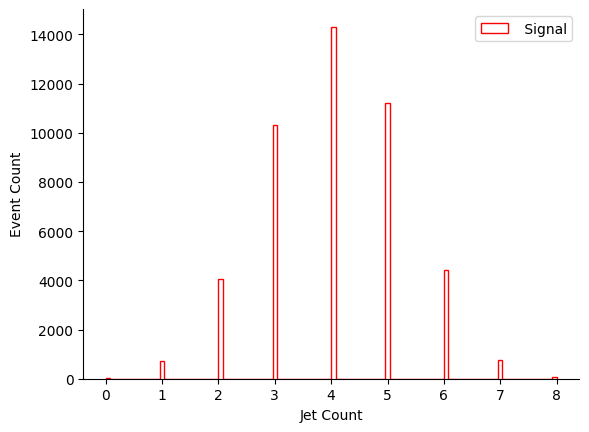

In [4]:
fig , ax0 = plt.subplots()

ax0.hist(df['Jet Count'] , histtype = 'step', bins = 100 , color = 'red' , label = ' Signal' )
# ax1.hist(y , histtype = 'step', bins = 100 , color = 'black' , label = ' Background' )

ax0.spines[['top','right']].set_visible(False)
ax0.set_xlabel('Jet Count')
ax0.set_ylabel('Event Count')
ax0.legend()

plt.show()

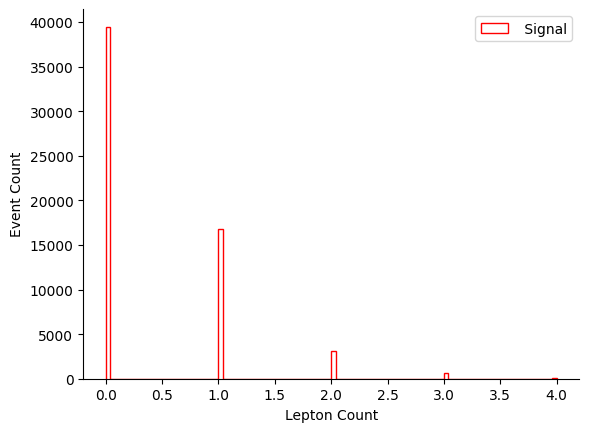

In [5]:
fig , ax01 = plt.subplots()

ax01.hist(df2['Lepton Count'] , histtype = 'step', bins = 100 , color = 'red' , label = ' Signal' )
# ax1.hist(y , histtype = 'step', bins = 100 , color = 'black' , label = ' Background' )

ax01.spines[['top','right']].set_visible(False)
ax01.set_xlabel('Lepton Count')
ax01.set_ylabel('Event Count')
ax01.legend()

plt.show()

## Require 4 or more jets

In [6]:
df = df[df['Jet Count']>3]

In [7]:
print(f'{len(df)} events survived')

30764 events survived


## Deploy Invariant mass Lorentz Vector Computations

In [8]:
import ROOT
import numpy as np

# Constants
M_Z = 90.0  # GeV
M_W = 81.0  # GeV
M_H = 150.0  # GeV

# Function to calculate invariant mass of two jets
def calculate_invariant_mass(jet1, jet2):
    return (jet1 + jet2).M()

# Function to process each event
def process_event(jet_pts, jet_etas, jet_phis, jet_masses):
    n_jets = len(jet_pts)
    jets = []

    # Build TLorentzVector for each jet
    for pt, eta, phi, mass in zip(jet_pts, jet_etas, jet_phis, jet_masses):
        jet = ROOT.TLorentzVector()
        jet.SetPtEtaPhiM(pt, eta, phi, mass)
        jets.append(jet)

    # Step 1: Find di-jet closest to M_Z or M_W
    best_mass_diff = float('inf')
    best_pair = None
    best_four_momentum = None

    for i in range(n_jets):
        for j in range(i + 1, n_jets):
            dijet = jets[i] + jets[j]
            dijet_mass = dijet.M()
            mass_diff = min(abs(dijet_mass - M_Z), abs(dijet_mass - M_W))

            if mass_diff < best_mass_diff:
                best_mass_diff = mass_diff
                best_pair = (i, j)
                best_four_momentum = dijet

    # Remove the selected jets from the list
    remaining_jets = [jets[k] for k in range(n_jets) if k not in best_pair]

    # Step 2: Find combination closest to M_H using remaining jets and best_pair
    best_h_mass_diff = float('inf')
    best_h_four_momentum = None
    best_h_jets = None

    for i in range(len(remaining_jets)):
        for j in range(i + 1, len(remaining_jets)):
            dijet_h = remaining_jets[i] + remaining_jets[j] + best_four_momentum
            dijet_h_mass = dijet_h.M()
            h_mass_diff = abs(dijet_h_mass - M_H)

            if h_mass_diff < best_h_mass_diff:
                best_h_mass_diff = h_mass_diff
                best_h_four_momentum = dijet_h
                best_h_jets = (remaining_jets[i], remaining_jets[j])

    # Return four-momenta of the jets, W/Z system, and H system
    jet1, jet2 = jets[best_pair[0]], jets[best_pair[1]]
    jet3, jet4 = best_h_jets
    return jet1, jet2, jet3, jet4, best_four_momentum, best_h_four_momentum

# Process the DataFrame and extract relevant four-momenta
results = []

for _, row in df.iterrows():
    jet_pts = row['Jet.PT']
    jet_etas = row['Jet.Eta']
    jet_phis = row['Jet.Phi']
    jet_masses = row['Jet.Mass']

    jets = process_event(jet_pts, jet_etas, jet_phis, jet_masses)
    results.append(jets)

# Add individual jet four-momenta to the DataFrame
for i in range(1, 5):
    df[f'Jet{i}_FourMomentum'] = [jets[i - 1] for jets in results]

# Add WZ and H system four-momenta to the DataFrame
df['WZ_FourMomentum'] = [jets[4] for jets in results]
df['H_FourMomentum'] = [jets[5] for jets in results]


## Store the relevent jets and their kinematics

In [9]:
# Extract properties for each jet's four-momentum and add them to the DataFrame
for i in range(1, 5):
    df[f'Jet{i}_PT'] = df[f'Jet{i}_FourMomentum'].apply(lambda jet: jet.Pt() if isinstance(jet, ROOT.TLorentzVector) else None)
    df[f'Jet{i}_Energy'] = df[f'Jet{i}_FourMomentum'].apply(lambda jet: jet.E() if isinstance(jet, ROOT.TLorentzVector) else None)
    df[f'Jet{i}_Theta'] = df[f'Jet{i}_FourMomentum'].apply(lambda jet: jet.Theta() if isinstance(jet, ROOT.TLorentzVector) else None)
    df[f'Jet{i}_Phi'] = df[f'Jet{i}_FourMomentum'].apply(lambda jet: jet.Phi() if isinstance(jet, ROOT.TLorentzVector) else None)

# Combine all jet properties into tuples for sorting
df['Jet_Properties'] = df.apply(
    lambda row: list(
        zip(
            [row[f'Jet{i}_PT'] for i in range(1, 5)],
            [row[f'Jet{i}_Energy'] for i in range(1, 5)],
            [row[f'Jet{i}_Theta'] for i in range(1, 5)],
            [row[f'Jet{i}_Phi'] for i in range(1, 5)],
        )
    ),
    axis=1,
)

# Sort jets by PT and update DataFrame columns
def sort_jets_by_pt(jets):
    # Sort jets by PT (index 0 of each tuple) in descending order
    sorted_jets = sorted(jets, key=lambda jet: jet[0], reverse=True)
    # Separate properties back into individual lists
    sorted_pt, sorted_energy, sorted_theta, sorted_phi = zip(*sorted_jets)
    return sorted_pt, sorted_energy, sorted_theta, sorted_phi

df[['Sorted_PT', 'Sorted_Energy', 'Sorted_Theta', 'Sorted_Phi']] = df['Jet_Properties'].apply(
    lambda jets: pd.Series(sort_jets_by_pt(jets))
)

# Update sorted jets into their respective Jet1, Jet2, etc. columns
for i in range(1, 5):
    df[f'Jet{i}_PT'] = df['Sorted_PT'].apply(lambda x: x[i - 1])
    df[f'Jet{i}_Energy'] = df['Sorted_Energy'].apply(lambda x: x[i - 1])
    df[f'Jet{i}_Theta'] = df['Sorted_Theta'].apply(lambda x: x[i - 1])
    df[f'Jet{i}_Phi'] = df['Sorted_Phi'].apply(lambda x: x[i - 1])

# Drop intermediate columns to keep the DataFrame clean
df.drop(columns=['Jet_Properties', 'Sorted_PT', 'Sorted_Energy', 'Sorted_Theta', 'Sorted_Phi'], inplace=True)

## Plot the jet and their distributions

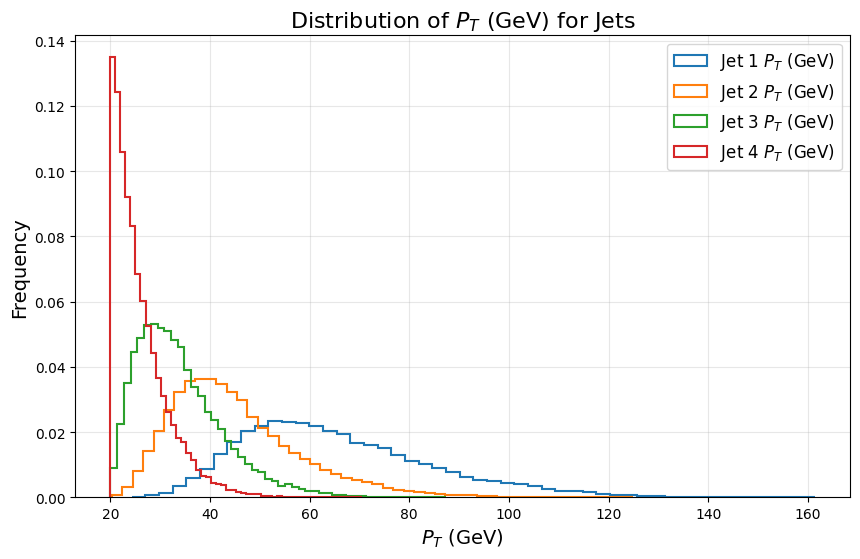

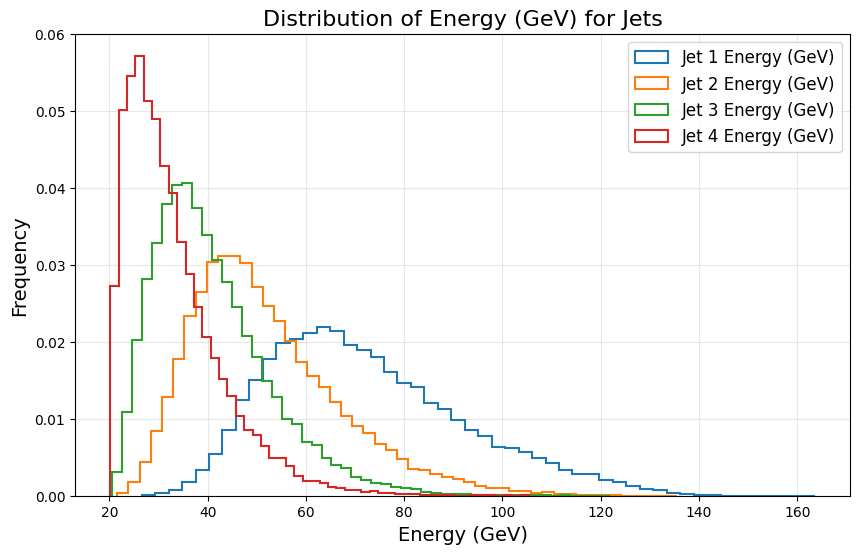

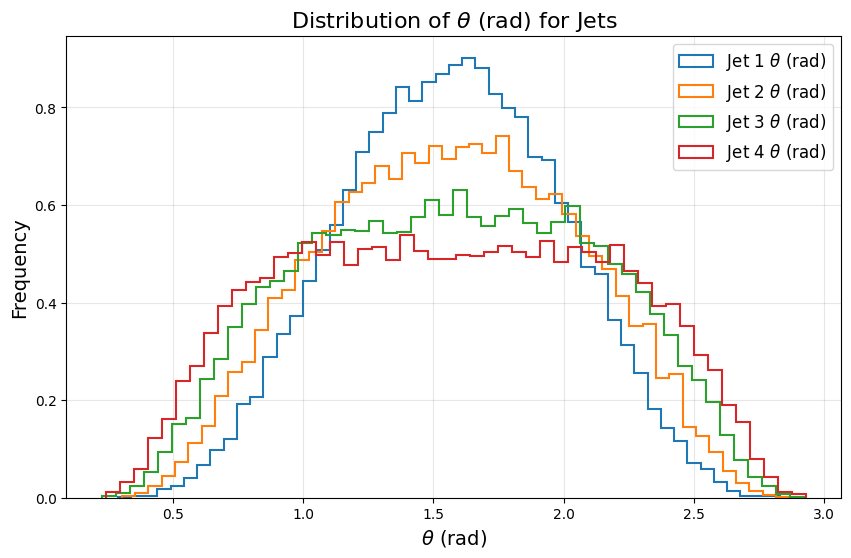

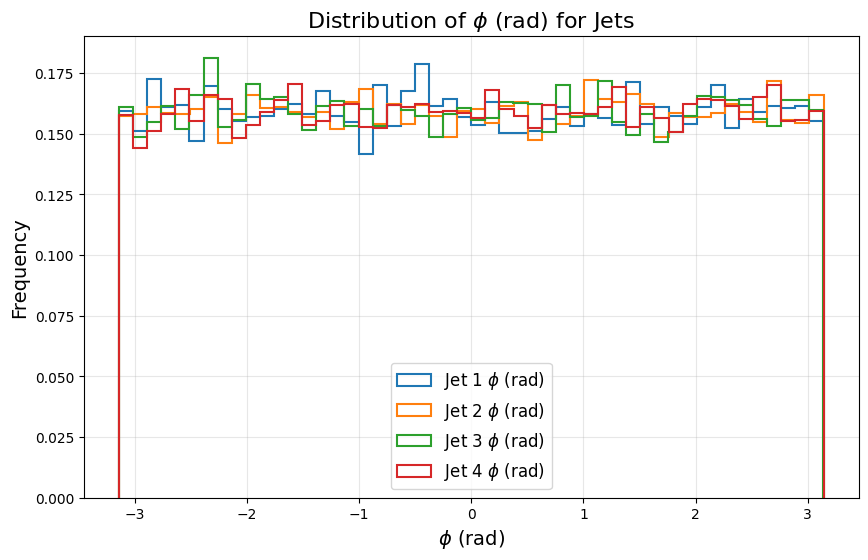

In [10]:
# Plot the distributions of PT, Energy, Theta, and Phi for each jet
kinematics = ['PT', 'Energy', 'Theta', 'Phi']
labels = [r'$P_T$ (GeV)', r'Energy (GeV)', r'$\theta$ (rad)', r'$\phi$ (rad)']

for kin, label in zip(kinematics, labels):
    plt.figure(figsize=(10, 6))
    for i in range(1, 5):  # Iterate over Jet1, Jet2, Jet3, Jet4
        plt.hist(
            df[f'Jet{i}_{kin}'].dropna(),
            density = True ,
            bins=50,
            histtype='step',  # Line-only histogram
            linewidth=1.5,    # Adjust line width for better visibility
            label=f'Jet {i} {label}'
        )
    plt.xlabel(label, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Distribution of {label} for Jets', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()


## The missing transverse energy

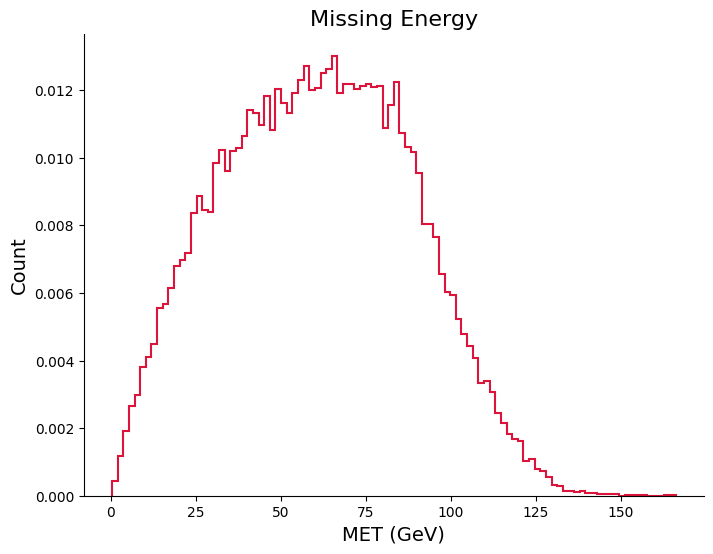

In [11]:
fig, ay2 = plt.subplots(figsize=(8, 6))

# Plot W/Z invariant mass as a step histogram
# ay2.hist(df['MissingET.MET'].apply(lambda x : x[0]).dropna(), bins=100, histtype='step', color='crimson', linewidth=1.5, label=r'$M_{W/Z}$')
ay2.hist(df2['MissingET.MET'].dropna(), bins=100, density = True ,  histtype='step', color='crimson', linewidth=1.5, label=r'$M_{W/Z}$')

# # Add vertical lines for expected masses
# ay2.axvline(90, color='red', linestyle='--', label=r'Expected $M_Z$ (90 GeV)')
# ay2.axvline(81, color='green', linestyle='--', label=r'Expected $M_W$ (81 GeV)')

# Customize spines
ay2.spines['top'].set_visible(False)
ay2.spines['right'].set_visible(False)

# Labels and title
ay2.set_xlabel(r'MET (GeV)', fontsize=14)
ay2.set_ylabel('Count', fontsize=14)
ay2.set_title('Missing Energy', fontsize=16)

# Add legend
# ay2.legend(fontsize=12)

# Add grid
# ay2.grid(True, alpha=0.3)

# Show the plot
plt.show()

## The W or Z invariant masses

In [12]:
# Add a new column for W/Z invariant mass directly from the stored four-momentum
df['WZ_InvariantMass'] = df['WZ_FourMomentum'].apply(lambda x: x.M() if x else None)


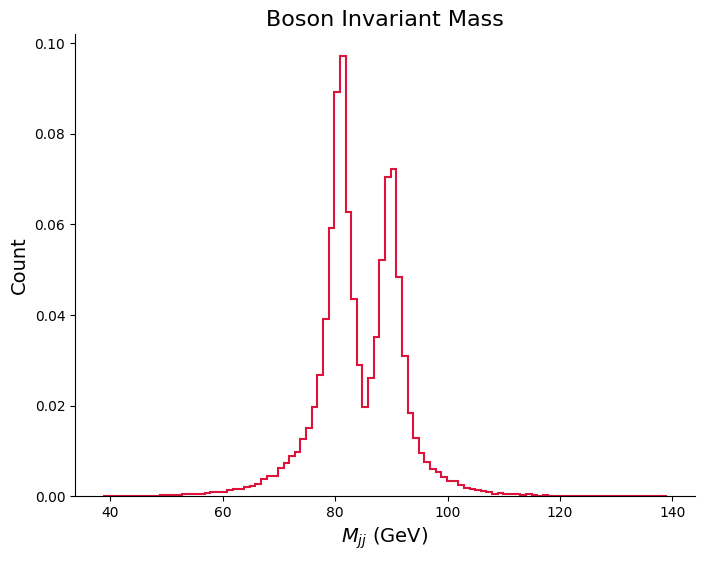

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot W/Z invariant mass as a step histogram
ax1.hist(df['WZ_InvariantMass'].dropna(), bins=100, density = True , histtype='step', color='crimson', linewidth=1.5, label=r'$M_{W/Z}$')

# # Add vertical lines for expected masses
# ax1.axvline(90, color='red', linestyle='--', label=r'Expected $M_Z$ (90 GeV)')
# ax1.axvline(81, color='green', linestyle='--', label=r'Expected $M_W$ (81 GeV)')

# Customize spines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Labels and title
ax1.set_xlabel(r'$M_{jj}$ (GeV)', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)
ax1.set_title('Boson Invariant Mass', fontsize=16)

# Add legend
# ax1.legend(fontsize=12)

# Add grid
# ax1.grid(True, alpha=0.3)

# Show the plot
plt.show()

## The Scalar invariant mass

In [14]:
# Add a new column for W/Z invariant mass directly from the stored four-momentum
df['Total_InvariantMass'] = df['H_FourMomentum'].apply(lambda x: x.M() if x else None)


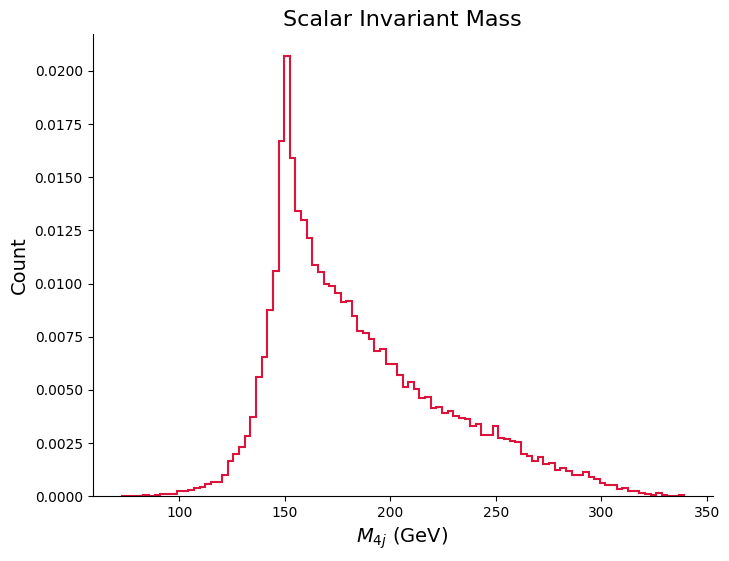

In [15]:
fig, ax2 = plt.subplots(figsize=(8, 6))

# Plot W/Z invariant mass as a step histogram
ax2.hist(df['Total_InvariantMass'].dropna(), bins=100, density = True , histtype='step', color='crimson', linewidth=1.5, label=r'$M_{W/Z}$')

# # Add vertical lines for expected masses
# ax2.axvline(90, color='red', linestyle='--', label=r'Expected $M_Z$ (90 GeV)')
# ax2.axvline(81, color='green', linestyle='--', label=r'Expected $M_W$ (81 GeV)')

# Customize spines
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Labels and title
ax2.set_xlabel(r'$M_{4j}$ (GeV)', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)
ax2.set_title('Scalar Invariant Mass', fontsize=16)

# Add legend
# ax2.legend(fontsize=12)

# Add grid
# ax2.grid(True, alpha=0.3)

# Show the plot
plt.show()

## The Machine Learning Dataframe

In [28]:
df_80 = df[['MissingET.MET',
       'Jet1_Energy', 'Jet1_Theta', 'Jet1_Phi', 'Jet2_Energy',
       'Jet2_Theta', 'Jet2_Phi', 'Jet3_Energy', 'Jet3_Theta',
       'Jet3_Phi', 'Jet4_Energy', 'Jet4_Theta', 'Jet4_Phi',
       'Total_InvariantMass']]

df_80['MissingET.MET'] = df_80['MissingET.MET'].apply(lambda x : x[0])

/tmp/ipykernel_23648/2204055994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_80['MissingET.MET'] = df_80['MissingET.MET'].apply(lambda x : x[0])


In [29]:
df_80

,MissingET.MET,Jet1_Energy,Jet1_Theta,Jet1_Phi,Jet2_Energy,Jet2_Theta,Jet2_Phi,Jet3_Energy,Jet3_Theta,Jet3_Phi,Jet4_Energy,Jet4_Theta,Jet4_Phi,Total_InvariantMass
0,15.627408,45.114895,1.545486,-1.554533,55.741535,0.905632,0.644921,32.374711,1.579828,-2.896415,44.400410,2.346691,-2.517485,170.721579
5,62.298000,63.402122,0.835253,-2.838446,42.387278,0.922869,-2.446858,41.499215,2.533818,-0.641531,46.945849,2.669867,-2.049588,170.866444
6,7.463618,108.234298,1.430247,-2.429945,70.984181,2.056646,1.518842,46.303675,1.600990,0.419179,39.032177,1.919314,-0.854040,261.871683
7,15.987584,103.942959,1.305793,-3.034244,32.329886,1.416583,-0.101401,27.864018,1.482922,-0.679700,29.762717,2.348803,0.624202,190.501675
8,7.204116,66.007204,1.740931,-2.961723,53.220819,2.257317,1.693388,51.567661,0.887524,1.433559,27.969438,1.875817,-2.537011,170.732818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45865,7.824889,65.534834,2.319011,-0.531248,59.041859,0.947084,-0.925525,41.566772,2.061389,1.900645,60.731824,0.467928,2.743483,222.498063
45866,2.811266,68.596528,1.294992,-1.378455,48.028127,1.336750,0.038838,35.387408,2.059138,2.835738,39.384704,0.848329,-1.071354,164.591726
45867,3.986369,116.041377,1.047814,0.982441,31.942273,1.209363,2.033970,42.986205,2.566633,-2.085857,26.970432,0.954539,3.070085,191.657201
45868,9.796456,46.663642,2.038866,-2.693327,53.384066,0.694385,2.431432,55.564312,2.483142,-2.308007,30.095917,0.930536,-0.115731,173.381745


In [30]:
print(f' Has {df_80.shape[0]} rows and {df_80.shape[1]} columns')

 Has 30764 rows and 14 columns


## Saving the dataframe

In [31]:
csv_file_path = '/home/physics/Project_CSV_EVENTS/For_The_Paper/ML_sig.csv'

In [32]:
df_80

,MissingET.MET,Jet1_Energy,Jet1_Theta,Jet1_Phi,Jet2_Energy,Jet2_Theta,Jet2_Phi,Jet3_Energy,Jet3_Theta,Jet3_Phi,Jet4_Energy,Jet4_Theta,Jet4_Phi,Total_InvariantMass
0,15.627408,45.114895,1.545486,-1.554533,55.741535,0.905632,0.644921,32.374711,1.579828,-2.896415,44.400410,2.346691,-2.517485,170.721579
5,62.298000,63.402122,0.835253,-2.838446,42.387278,0.922869,-2.446858,41.499215,2.533818,-0.641531,46.945849,2.669867,-2.049588,170.866444
6,7.463618,108.234298,1.430247,-2.429945,70.984181,2.056646,1.518842,46.303675,1.600990,0.419179,39.032177,1.919314,-0.854040,261.871683
7,15.987584,103.942959,1.305793,-3.034244,32.329886,1.416583,-0.101401,27.864018,1.482922,-0.679700,29.762717,2.348803,0.624202,190.501675
8,7.204116,66.007204,1.740931,-2.961723,53.220819,2.257317,1.693388,51.567661,0.887524,1.433559,27.969438,1.875817,-2.537011,170.732818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45865,7.824889,65.534834,2.319011,-0.531248,59.041859,0.947084,-0.925525,41.566772,2.061389,1.900645,60.731824,0.467928,2.743483,222.498063
45866,2.811266,68.596528,1.294992,-1.378455,48.028127,1.336750,0.038838,35.387408,2.059138,2.835738,39.384704,0.848329,-1.071354,164.591726
45867,3.986369,116.041377,1.047814,0.982441,31.942273,1.209363,2.033970,42.986205,2.566633,-2.085857,26.970432,0.954539,3.070085,191.657201
45868,9.796456,46.663642,2.038866,-2.693327,53.384066,0.694385,2.431432,55.564312,2.483142,-2.308007,30.095917,0.930536,-0.115731,173.381745


In [33]:

df_80.to_csv(csv_file_path, index=False)

print(f"DataFrame saved successfully to {csv_file_path}")

DataFrame saved successfully to /home/physics/Project_CSV_EVENTS/For_The_Paper/ML_sig.csv
